Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

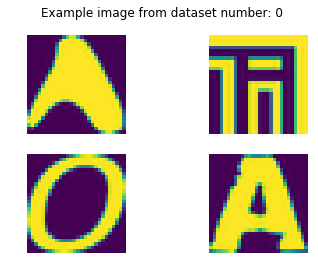

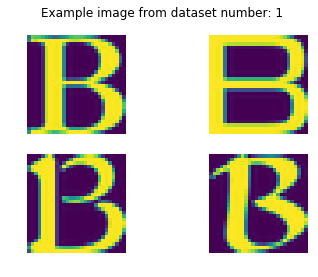

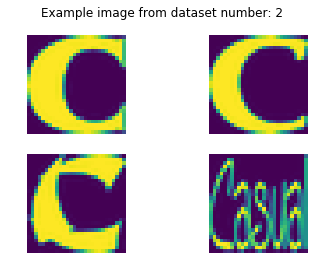

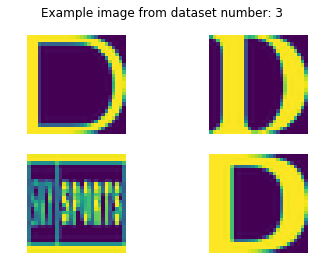

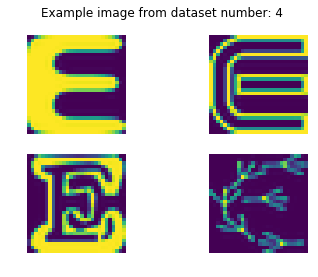

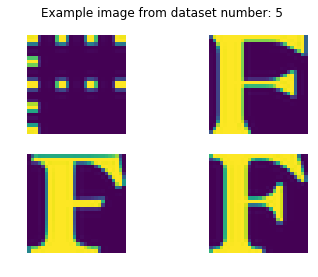

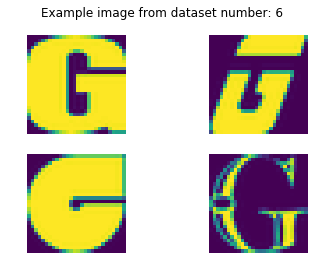

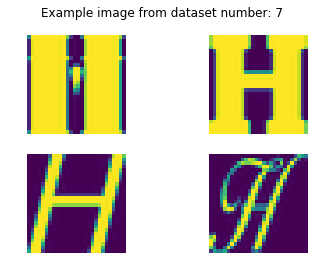

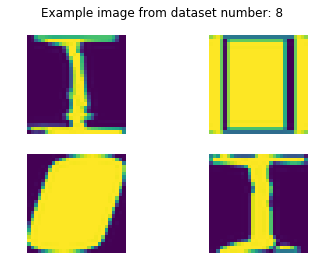

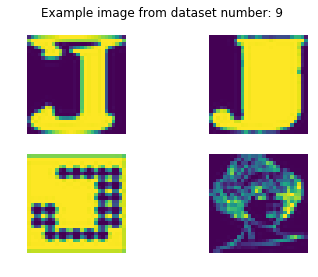

In [5]:
nbClass = 10
indices = range(nbClass)

for i in indices:
  pickle_file = train_datasets[i]
  try:
    with open(pickle_file, 'rb') as f:
      set = pickle.load(f)
      #pick 4 random sample inside the dataset
      idx = np.random.choice(np.arange(set.shape[0]),4,replace=False)
      plt.figure()
      plt.suptitle('Example image from dataset number: '+str(i))
      for j,randIdx in enumerate(idx):
        plt.subplot(2,2,j+1)
        plt.imshow(np.squeeze(set[randIdx,:,:]))
        plt.axis('off')
  except Exception as e:
    print('Unable to process data from', pickle_file, ':', e)
    raise
    

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [6]:
def printClassRatioFromPickleFolders(folders, setName):
  total=0
  individual=np.zeros(len(folders))
  for i,f in enumerate(folders):
    with open(f, 'rb') as f:
      set = pickle.load(f)
      individual[i]=set.shape[0]
      total = total+set.shape[0]
  print('Class histogram for '+setName+' set is '+str(individual/total))

printClassRatioFromPickleFolders(test_datasets,'test')
printClassRatioFromPickleFolders(train_datasets,'train')

Class histogram for test set is [ 0.09997864  0.10003204  0.10003204  0.10003204  0.10003204  0.09997864
  0.09997864  0.09997864  0.09997864  0.09997864]
Class histogram for train set is [ 0.09999546  0.09999924  0.10000113  0.09999924  0.10000113  0.10000113
  0.10000113  0.10000113  0.10000113  0.09999924]


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [7]:
'''
  This step is here to merge data from different classes (in different pickle files) into a single pickle file
  for later use. The good point is that one can choose the overall size of the training set.
'''
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters having same label to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          # take the vsize_per_class first samples
          valid_letter = letter_set[:vsize_per_class, :, :]
          # Add those to the valid dataset
          valid_dataset[start_v:end_v, :, :] = valid_letter
          # they all have the same label (the current one)
          valid_labels[start_v:end_v] = label
          # Then increment the stack counter
          start_v += vsize_per_class
          end_v += vsize_per_class
        
        #take the following samples for training
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        # Add them to the training dataset
        train_dataset[start_t:end_t, :, :] = train_letter
        # Assign the label in the corresponding array
        train_labels[start_t:end_t] = label
        # Increment both stack counters
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [8]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Now checking training dataset


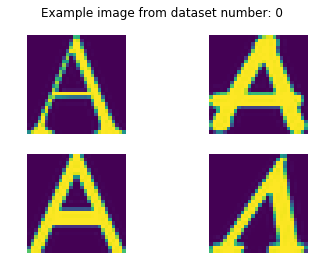

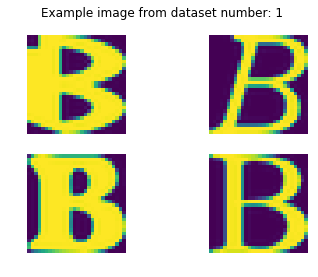

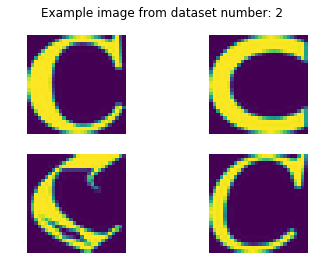

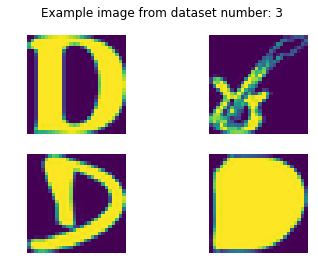

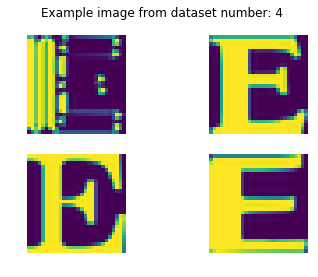

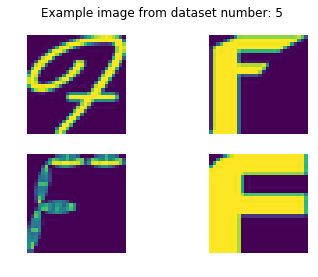

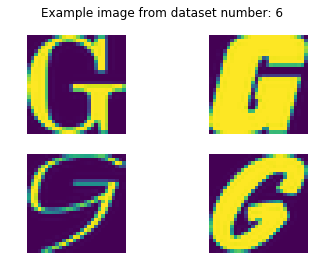

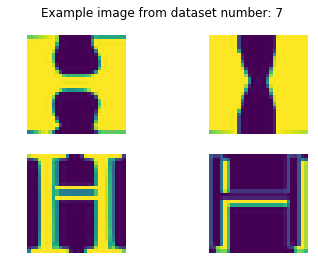

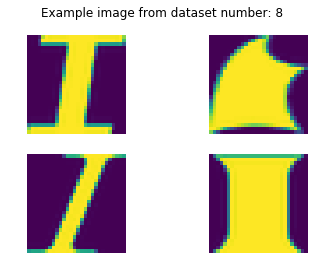

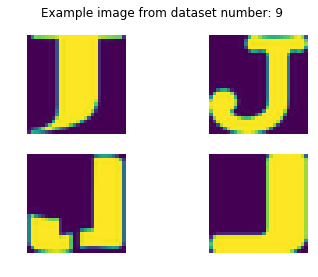

Now checking test dataset


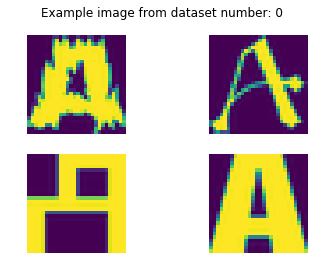

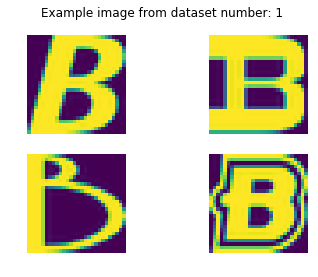

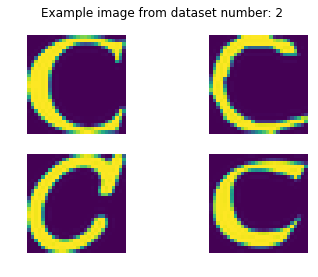

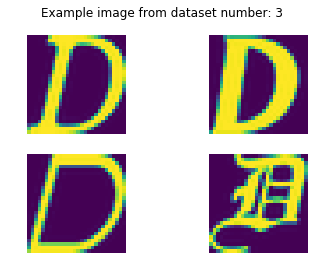

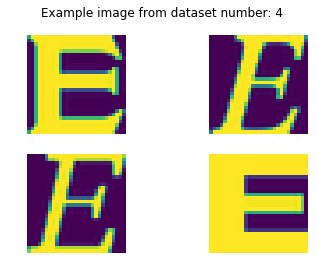

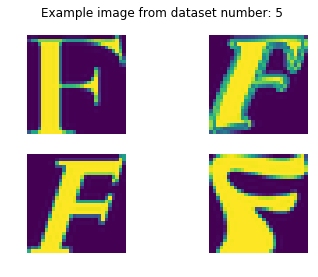

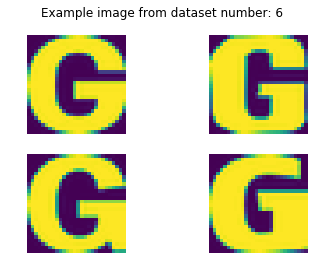

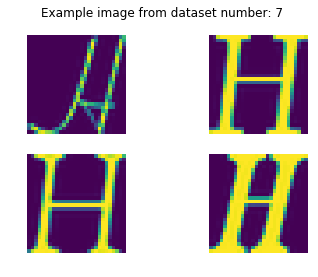

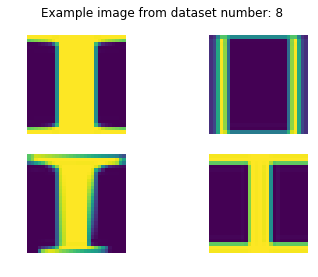

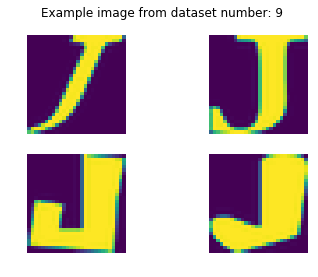

Now checking validation dataset


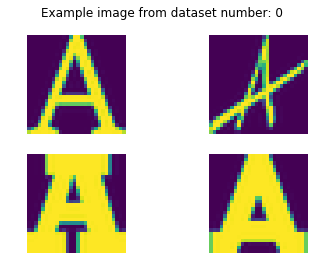

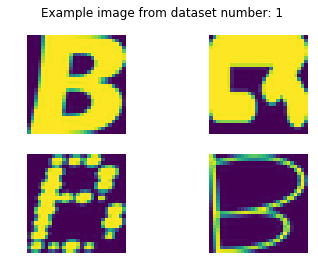

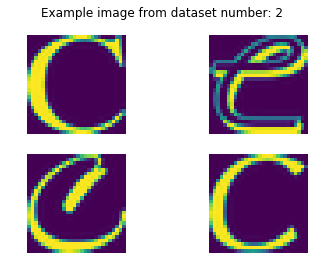

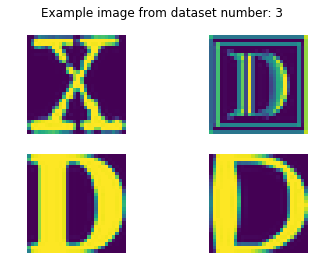

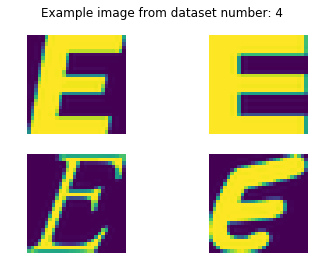

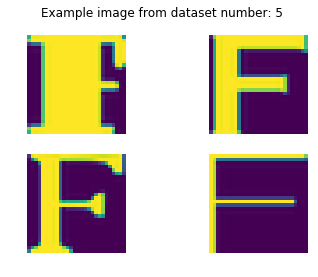

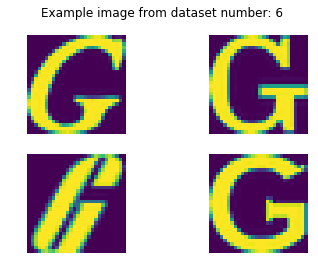

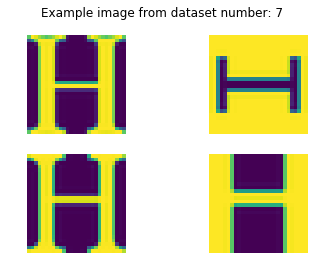

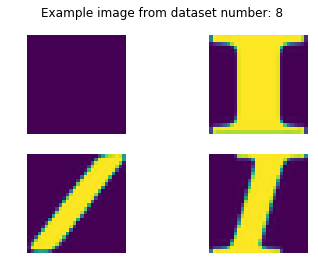

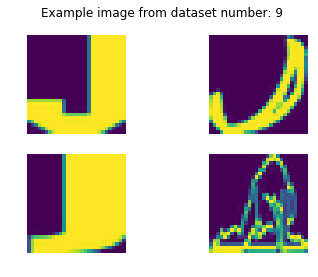

In [9]:
def checkDataset(data,labels, datasetName):
  print('Now checking '+datasetName+' dataset')
  classLabels = np.unique(labels)
  nbClass = len(classLabels)

  for label in classLabels:
      #pick 4 random sample inside the dataset with current label
      idx = np.random.choice(np.squeeze(np.argwhere(labels==label)),4,replace=False)
      plt.figure()
      plt.suptitle('Example image from dataset number: '+str(label))
      for j,randIdx in enumerate(idx):
        plt.subplot(2,2,j+1)
        plt.imshow(np.squeeze(data[randIdx,:,:]))
        plt.axis('off')
      plt.show()

checkDataset(train_dataset,train_labels,'training')
checkDataset(test_dataset,test_labels,'test')
checkDataset(valid_dataset,valid_labels,'validation')

Finally, let's save the data for later reuse:

In [10]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [12]:
def GetPercentageOfUselessDup(data):
  #largest = setA if len(setA)>len(setB) else setB
  #smallest = setA if len(setA)<=len(setB) else setB

  #dIdx = [i for i in range(largest.shape[0]) if list(largest[i,:,:].flatten()) in\
  #  [list(smallest[j,:,:].flatten()) for j in range(smallest.shape[0])]]
  #return len(dIdx)
  nbOfSample=data.shape[0]
  u,counts=np.unique(np.reshape(data,(nbOfSample,-1)),axis=0,return_counts=True)
  nbOfUsefulSample=counts.size
  return (nbOfSample-nbOfUsefulSample)/nbOfSample

print('train ratio of useless duplicate is : '+str(GetPercentageOfUselessDup(train_dataset)))
print('valid ratio of useless duplicate is : '+str(GetPercentageOfUselessDup(valid_dataset)))
print('test ratio of useless duplicate is : '+str(GetPercentageOfUselessDup(test_dataset)))

train ratio of useless duplicate is : 0.064045
valid ratio of useless duplicate is : 0.0126
test ratio of useless duplicate is : 0.0201


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [14]:
from sklearn import linear_model

#This is not even 
def trainModel(nSamples,data,label):
  # skl is wants data to be: dimension 0: list of samples, dimension 1: features
  X = data[:nSamples,:,:].reshape(-1, np.prod(data.shape[1:3]))
  y = label[:nSamples]

  # run the classifier
  model = linear_model.LogisticRegression(multi_class='multinomial',solver='saga')
  model.fit(X, y)
  return model

def testModel(model, data, label):
  X = data.reshape(-1, np.prod(data.shape[1:3]))
  test=label
  correct = model.predict(X) == label
  return np.count_nonzero(correct)/correct.size
    
# plot result function of training samples
nbSamplesConfig=[50, 100, 1000, 5000]

scores = np.zeros(len(nbSamplesConfig))
for idx, nbSample in enumerate(nbSamplesConfig):
  model = trainModel(nbSample,train_dataset,train_labels)
  scores[idx]= testModel(model,test_dataset,test_labels)

/opt/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


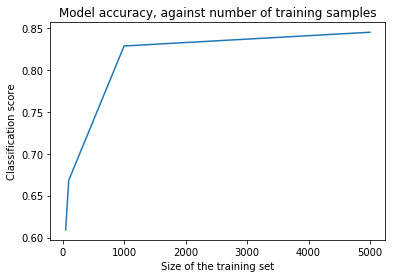

In [15]:
plt.plot(nbSamplesConfig,scores)
plt.xlabel('Size of the training set')
plt.ylabel('Classification score')
plt.legend(loc="lower right", fontsize='small')
plt.title('Model accuracy, against number of training samples')
plt.show()

## Differenciating the multi-class logisitc loss
We recall that logisitc loss L, reads:
\begin{align*}
  L(W,b) = c(s(Wx+b))
\end{align*}

Where:
  * $W$ is the weight, a $m\times n$ matrix, where each element is indexed: $W_{i,j}$
  * $b$ is the bias vector of size n, equivalent to the number of class
  * $c$ is the cross entropy function
  * $s$ is the softmax function

### Jacobian

We first recall that, for a function $\underset{\mathbb{R}^n}{f} \mapsto \underset{\mathbb{R}^n}{f(x)}$, we can derive the matrix of partial derivative, called the jacobian matrix:

\begin{align*}
  J=\begin{pmatrix}
    \frac{\partial f_0}{\partial x_0} & \frac{\partial f_0}{\partial x_1} & \dots & \frac{\partial f_0}{\partial x_n}\\
    \frac{\partial f_1}{\partial x_0} & \frac{\partial f_1}{\partial x_1} & \dots & \frac{\partial f_1}{\partial x_n}\\
  \vdots & \vdots & \vdots & \vdots \\
  \frac{\partial f_n}{\partial x_0} & \frac{\partial f_n}{\partial x_1} & \dots & \frac{\partial f_n}{\partial x_n}
\end{pmatrix}
\end{align*}

### Jacobian of $c$ for a single sample

We recall that, given a vector $v$ of size $n$, and a set of probability (for each label) p of size $n$ (the number of classes), we have:
\begin{align*}
  c(v) = -\sum_{k=0}^{n-1} p_k log(v_k)
\end{align*}

Then the jacobian becomes a simple row vector (1 output, multiple input variables) which is very simple to compute:
\begin{align*}
  & \begin{pmatrix}
    \frac{\partial c}{\partial v_0} , \dots, \frac{\partial c}{\partial v_{n-1}} \end{pmatrix} \\
  = &\begin{pmatrix} -\frac{p_0}{v_0}, \dots, -\frac{p_{n-1}}{v_{n-1}} \end{pmatrix}
\end{align*}




### Derivation of the jacobian for the softmax
For the case of softmax, given a vector $v$ of size $n$ (the number of classes), we have also an output of size n:
\begin{align*}
  s(v)_i = s_i = \frac{e^{v_i}}{\sum_{k=0}^{n-1}e^{v_k}}
\end{align*}

Let's now try to find $\frac{\partial s_i}{\partial v_j}$:

In the case $i\neq j$, we have to differentiate a function $f$ of the form $f(x)=\frac{a}{b+e^x}$, where $a=e^{v_i}$ and $b=\sum_{k\neq j}^{n-1}e^{v_k}$ which can be computed thanks to the composition rule between $\frac{a}{x}$ and $b+e^x$: 
\begin{align*}
  f'(x) &= -\frac{a}{\left(b+e^x\right)^2} \times e^x\\
  &= -\frac{ae^x}{\left(b+e^x\right)^2}
\end{align*}
From there we can express:
\begin{align*}
  \frac{\partial s_i}{\partial v_j} &= -\frac{e^{v_i+v_j}}{\left(\sum_{k=0}^{n-1}e^{v_k}\right)^2} \\
  &= -s_i s_j
\end{align*}

Otherwise we have to differentiate a function $f$ of the form $f(x)=\frac{a e^x}{b+e^x}$, where $a=1$ and $b=\sum_{k\neq i}^{n-1}e^{v_k}$ which can be computed thanks to the multiplication rule between $\frac{a}{b+e^x}$ and $e^x$:
\begin{align*}
  f'(x) &= -\frac{ae^x}{\left(b+e^x\right)^2} \times e^x + \frac{a}{b+e^x} \times e^x\\
  &= -\frac{ae^{2x}}{\left(b+e^x\right)^2} + \frac{ae^x}{b+e^x}
\end{align*}
From there we can express:
\begin{align*}
  \frac{\partial s_i}{v_i} &= -\frac{e^{2v_i}}{\left(\sum_{k=0}^{n-1}e^{v_k}\right)^2} + \frac{e^{v_i}}{\sum_{k=0}^{n-1}e^{v_k}} \\
  &= \frac{e^{v_i}}{\sum_{k=0}^{n-1}e^{v_k}} \left( 1 - \frac{e^{v_i}}{\sum_{k=0}^{n-1}e^{v_k}}\right)\\
  &= s_i (1-s_i)
\end{align*}

### Jacobian of the linear part
We recall, that our linear model, for a single sample (feature vector) x, reads $f(x) = Wx+b$, and we are interested in derivating this expression with regard to $W_{ij}$ and $b_i$.

\begin{align*}
  \frac{\partial f_i}{\partial W_{kj}} &= \begin{cases} x_k \quad &\text{ if } k=i \\ 0 & \text{otherwise} \end{cases}
\end{align*}

\begin{align*}
  \frac{\partial f_i}{\partial b_{j}} &= \begin{cases} 1 \quad &\text{ if } i=j \\ 0 & \text{otherwise} \end{cases}
\end{align*}

### Composition Rule
Let's recall the composition rule with 3 fnctions: $f,g$ and $h$ in $x$:
\begin{align*}
  (f \circ g \circ h)'(x) = (f' \circ g \circ h)(x) \times (g' \circ h)(x) \times h'(x)
\end{align*}

### Composition rule with partial derivatives 

We recall the chain rule in higher dimensions, using the jacobian matrix (matrix of partial derivative):

\begin{align*}
  J_{f\circ g}(a) = J_{f}(g(a)) J_g(a)
\end{align*}

Which, gives, in the case of 3 mappings:

\begin{align*}
  J_{f\circ g \circ h}(a) = J_{f}(g\circ h(a)) J_g(h(a)) J_h(a)
\end{align*}


## Gradient descent and convexity
We won't prove here that optimizing this multiclass logisitc regression in convex, but let's assume it is, and that we can use gradient descent on it

In [41]:
# Now doing this by hand

def crossEntropy(label,y):
  '''label and y are a nSample*nClass matrices'''
  #print('Cross input is '+str(label.shape)+'  '+str(y.shape))
  return -np.dot(label.flatten(),np.log(y).flatten())

def softmax(x):
  '''x is a nSample*nClass matrices'''
  #print('softmax input is '+str(x.shape))
  exp=np.exp(x)
  ret = (exp.T/exp.T.sum(axis=0)).T
  #print('softmax output should be same as input '+str(ret.shape))
  return ret

def linearModel(weight, bias, features):
  '''weight a nClass*nFeatures matrix
     bias a nClass vector
     features is a nSample*nFeatures matrix
     output should be a nSample*nClass matrix
    '''
  #print('linear input is '+str(weight.shape)+'  '+str(bias.shape)+'  '+str(features.shape))
  ret=np.dot(weight,features.T).T+bias
  #print('output should be compliant with labels '+str(ret.shape))
  return ret

def loss(weight,bias,features,labels):
  return crossEntropy(labels, softmax(linearModel(weight,bias,features)))




In [42]:
def gradientWb(weight, bias, features, labels):
  " return gradient for W and b as a tuple"
  nSample=labels.shape[0]
  nClass=labels.shape[1]
  nFeatures=weight.shape[1]
  gradW=np.zeros(weight.size)
  gradB=np.zeros(bias.size)
  for sample in range(nSample):
    # computing local values for reuse
    linLocal=linearModel(weight, bias, features[sample,:])
    softLocal=softmax(linLocal)
    # computing cross entropy jacobian for single sample
    Jcross_sol = -labels[sample,:]/softLocal
    Jcross_sol=Jcross_sol.reshape(1,-1)
    # computing softmax jacobian for single sample
    Jsoft_l = -np.outer(softLocal,softLocal)
    np.fill_diagonal(Jsoft_l,softLocal*(1-softLocal))
    # computing linear jacobian separately for W and b
    JlW = np.zeros((nClass,weight.size))
    Jlb = np.identity(bias.size)
    for i in range(nClass):
      JlW[i,i*nFeatures:(i+1)*nFeatures]=features[sample,:]
    Jprod=np.dot(Jcross_sol,Jsoft_l).reshape(1,-1)
    #print('Jprod is '+str(Jprod.shape)+' jlW is '+str(JlW.shape))
    gradW+=np.dot(Jprod,JlW).flatten()
    gradB+=np.dot(Jprod,Jlb).flatten()
  return gradW.reshape(weight.shape), gradB.reshape(bias.shape)

In [43]:
def makeMultiClassLabel(label,nbclass):
  '''Make 2d 1-hot encoded matrix from 1d integer list'''
  #nbclass=np.unique(label).size
  ret=np.zeros((label.size,nbclass))
  ret[(range(label.size),label)]=1 
  return ret

def selectData(nSamples,data,label):
  # We want data to be: dimension 0: list of samples, dimension 1: features
  x = data[:nSamples,:,:].reshape(-1, np.prod(data.shape[1:3]))
  y = makeMultiClassLabel(label[:nSamples],10)
  return x,y

In [58]:
stepLength = 1e-4
nbIter=500

#Select input data
nbSample=800
features, labels = selectData(nbSample,train_dataset,train_labels)

#Sizes
nbClass=labels.shape[1]
nbFeatures=features.shape[1]

#Perform gradient descent
w=np.random.rand(nbClass,nbFeatures)
b=np.random.rand(nbClass)
losslist = []
for i in range(nbIter):
  gW,gB=gradientWb(w, b, features, labels)
  w-=stepLength*gW
  b-=stepLength*gB
  l=loss(w, b, features, labels)
  #print('loss is '+str(l))
  losslist.append(l)

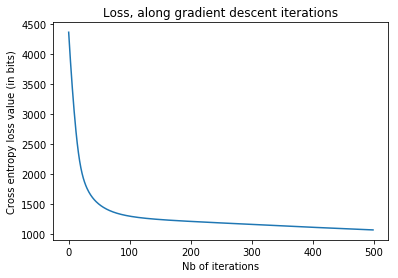

Accuracy is 0.7722


In [59]:
plt.figure()
plt.plot(np.arange(nbIter),losslist)
plt.xlabel('Nb of iterations')
plt.ylabel('Cross entropy loss value (in bits)')
plt.title('Loss, along gradient descent iterations')
plt.show()

nbSample=test_labels.size
nbClass=10
features, labels = selectData(nbSample,test_dataset,test_labels)

prediction = softmax(linearModel(w,b,features)).reshape(nbSample,nbClass).T
#print('prediction '+str(prediction))
#print('max pred '+str(prediction.max(axis=0)))
prediction=(prediction==prediction.max(axis=0)).T
#print('1 hot pred '+str(prediction))
#print('labels '+str(labels))
prediction=(prediction * labels)
#print('labels*pred '+str(prediction))

accuracy = np.count_nonzero(prediction)/prediction.shape[0]
print('Accuracy is '+str(accuracy))

## Simplified version

Following the chain rule, and given the fact that probability labels are one-hot encoded, we should be able to give a more simple version.

In this case, the Cross-entropy function jacobian for a single sample whose label is k looks like that:
\begin{align*}
  \begin{pmatrix} 0 & \dots & 0 & -\frac{1}{s_k} & 0 & \dots & 0\end{pmatrix}
\end{align*}

Then, there is only on useful row (the $k^{th}$ row) in the softmax jacobian:

\begin{align*}
  J_{soft}=\begin{pmatrix}
   0 & 0 & \dots & \dots & \dots & 0\\
   \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \\
   -s_k s_0 & -s_k s_1 & \dots & s_k(1-s_k) & \dots & -s_k s_{n-1}\\
   \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \\
   0 & 0 & \dots & \dots & \dots & 0\\
\end{pmatrix}
\end{align*}

Moreover, we recall that there was only one useful 

In [63]:
def gradientWbv1(weight, bias, features, labels):
  " return gradient for W and b as a tuple"
  nSample=labels.shape[0]
  nClass=labels.shape[1]
  nFeatures=weight.shape[1]
  gradW=np.zeros_like(weight)
  gradB=np.zeros_like(bias)
  for sample in range(nSample):
    # computing local values for reuse
    linLocal=linearModel(weight, bias, features[sample,:])
    softLocal=softmax(linLocal)
    # Right class idx
    rc = labels[sample,:].argmax()
    src=softLocal[rc]
    # Now jcross is a single value
    Jcross_sol = -1/src
    # Now Jsoft is a single value as well
    Jsoft_l = src*(1-src)
    # When looking carefully, we have Jcross_sol*Jsoft_l=src-1
    prod = src-1
    # Now we can directly update gradient
    gradW[rc,:]+=features[sample,:]*prod
    gradB[rc]+=prod
  return gradW, gradB

In [88]:
def gradientWbv2(weight, bias, features, labels):
  " Yeah, this one is a bit trickier to understand without pen and paper"
  softLocal=softmax(linearModel(weight, bias, features))
  rc = labels.argmax(axis=1)
  prod = softLocal[np.arange(labels.shape[0]),rc]-1
  gradW=np.dot(labels.T,(features.T*prod).T)
  gradB=np.dot(labels.T,prod)
  return gradW, gradB

In [109]:
stepLength = 5e-5
nbIter=1000

#Select input data
nbSample=2000
features, labels = selectData(nbSample,train_dataset,train_labels)

#Sizes
nbClass=labels.shape[1]
nbFeatures=features.shape[1]

#Perform gradient descent
w=np.random.rand(nbClass,nbFeatures)
b=np.random.rand(nbClass)
losslist = []
for i in range(nbIter):
  gW,gB=gradientWbv2(w, b, features, labels)
  w-=stepLength*gW
  b-=stepLength*gB
  l=loss(w, b, features, labels)
  #print('loss is '+str(l))
  losslist.append(l)

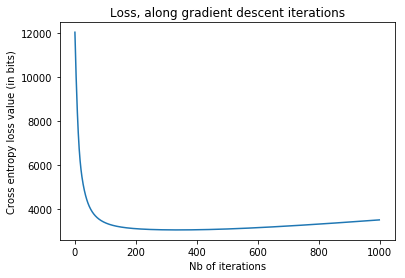

Accuracy is 0.8176


In [110]:
plt.figure()
plt.plot(np.arange(nbIter),losslist)
plt.xlabel('Nb of iterations')
plt.ylabel('Cross entropy loss value (in bits)')
plt.title('Loss, along gradient descent iterations')
plt.show()
nbSample=test_labels.size
nbClass=10
features, labels = selectData(nbSample,test_dataset,test_labels)
prediction = softmax(linearModel(w,b,features)).reshape(nbSample,nbClass).T
prediction=(prediction==prediction.max(axis=0)).T
prediction=(prediction * labels)
accuracy = np.count_nonzero(prediction)/prediction.shape[0]
print('Accuracy is '+str(accuracy))